In [ ]:
from base64 import b64encode
from google.colab import files
from google.colab.patches import cv2_imshow
from IPython.display import HTML
from PIL import Image
from tqdm.notebook import tqdm
import cv2
import numpy as np
import os
import torch

In [ ]:
# clone the dataset and yolo model weights
%cd /content/
!git clone https://github.com/COS30018-Assignment-Proejct-3/social-distancing.git

/content
Cloning into 'social-distancing'...
remote: Enumerating objects: 832, done.
remote: Total 832 (delta 0), reused 0 (delta 0), pack-reused 832
Receiving objects: 100% (832/832), 268.10 MiB | 49.63 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [ ]:
# helper function to display video
def display_avi_video(path):
    '''Display video in Colab.'''
    compressed_path = path.split('.')[0]
    compressed_path = 'compressed_' + compressed_path + '.mp4'

    if os.path.exists(compressed_path):
        os.remove(compressed_path)

    # Convert video
    os.system(f"ffmpeg -i {path} -vcodec libx264 {compressed_path}")

    # Show video
    mp4 = open(compressed_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

def display_mp4_video(path):
    # Show video
    mp4 = open(path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

In [ ]:
# check the video
filename = '/content/social-distancing/test/videos/vid3.mp4'
display_mp4_video(filename)

Output hidden; open in https://colab.research.google.com to view.

# Predict distance based on image pixel only

In [ ]:
# Load model
model = torch.hub.load('ultralytics/yolov5', 'custom', path = '/content/social-distancing/weights/best.pt')

model.cuda('cuda:0') # run this if CUDA is available

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


Fusing layers... 


  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



Model Summary: 232 layers, 7246518 parameters, 0 gradients
Adding AutoShape... 
YOLOv5 🚀 2021-5-26 torch 1.8.1+cu101 CUDA:0 (Tesla T4, 15109.75MB)



AutoShape(
  (model): Model(
    (model): Sequential(
      (0): Focus(
        (conv): Conv(
          (conv): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): BottleneckCSP(
        (cv1): Conv(
          (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (cv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (cv4): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
        (m): Sequential

In [ ]:
# calculate the center of the bounding box predicted by the model
def center_distance(xyxy1, xyxy2):
    '''Calculate the distance of the centers of the boxes.'''
    a, b, c, d = xyxy1
    x1 = int(np.mean([a, c]))
    y1 = int(np.mean([b, d]))

    e, f, g, h = xyxy2
    x2 = int(np.mean([e, g]))
    y2 = int(np.mean([f, h]))
    
    dist = np.linalg.norm([x1 - x2, y1 - y2])
    return dist, x1, y1, x2, y2

In [ ]:
# detect the people in the frame without bird's eye processing
def detect_people_on_frame(img, confidence, distance):
    '''Detect people on a frame and draw the rectangles and lines.'''
    results = model([img[:, :, ::-1]])  # Pass the frame through the model and get the boxes

    xyxy = results.xyxy[0].cpu().numpy()  # xyxy are the box coordinates
    #          x1 (pixels)  y1 (pixels)  x2 (pixels)  y2 (pixels)   confidence        class
    # tensor([[7.47613e+02, 4.01168e+01, 1.14978e+03, 7.12016e+02, 8.71210e-01, 0.00000e+00],
    #         [1.17464e+02, 1.96875e+02, 1.00145e+03, 7.11802e+02, 8.08795e-01, 0.00000e+00],
    #         [4.23969e+02, 4.30401e+02, 5.16833e+02, 7.20000e+02, 7.77376e-01, 2.70000e+01],
    #         [9.81310e+02, 3.10712e+02, 1.03111e+03, 4.19273e+02, 2.86850e-01, 2.70000e+01]])

    xyxy = xyxy[xyxy[:, 4] >= confidence]  # Filter desired confidence
    xyxy = xyxy[xyxy[:, 5] == 0]  # Consider only people
    xyxy = xyxy[:, :4]

    colors = ['green']*len(xyxy)
    for i in range(len(xyxy)):
        for j in range(i+1, len(xyxy)):
            # Calculate distance of the centers
            dist, x1, y1, x2, y2 = center_distance(xyxy[i], xyxy[j])
            if dist < distance:
                # If dist < distance, boxes are red and a line is drawn
                colors[i] = 'red'
                colors[j] = 'red'
                img = cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    for i, (x1, y1, x2, y2) in enumerate(xyxy):
        # Draw the boxes
        if colors[i] == 'green':
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    return img

In [ ]:
# detect the people in the image without bird's eye processing and inference the result on image
def detect_people_on_picture(aPath, aConfidence, aDistance):
    image_path = aPath
    image = cv2.imread(image_path)
    cv2_imshow(detect_people_on_frame(image, confidence = aConfidence, distance = aDistance))

In [ ]:
# inference a picture
detect_people_on_picture('/content/social-distancing/ori_images/image1.jpg', 0.5, 100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# detect the people in the video without bird's eye processing
def detect_people_on_video(filename, confidence=0.9, distance=60):
    '''Detect people on a video and draw the rectangles and lines.'''
    # Capture video
    cap = cv2.VideoCapture(filename)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    if os.path.exists('output.avi'):
        os.remove('output.avi')
    out = cv2.VideoWriter('output.avi', fourcc, fps, (width, height))

    # Iterate through frames and detect people
    vidlen = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=vidlen) as pbar:
        while cap.isOpened():
            # Read a frame
            ret, frame = cap.read()
            # If it's ok
            if ret == True:
                frame = detect_people_on_frame(frame, confidence, distance)
                # Write new video
                out.write(frame)
                pbar.update(1)
            else:
                break

    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
# inference on video
detect_people_on_video(filename, confidence=0.5)

In [ ]:
# view the output video
display_avi_video('output.avi')

Output hidden; open in https://colab.research.google.com to view.

# Bird's-eye view

In [ ]:
# displaying first frame of video
cap = cv2.VideoCapture(filename)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
ret, image = cap.read()
if ret:
    cv2_imshow(image)

# draw out the region to be analysed using bird's-eye view
region = [[width, 0], [width - 300, 1000], [0, 550], [width - 750, 0]]
region = np.array(region, dtype=np.int32).reshape((-1, 1, 2))
region_image = cv2.polylines(image.copy(), [region], True, (0, 0, 255), 2)
cv2_imshow(region_image)

Output hidden; open in https://colab.research.google.com to view.

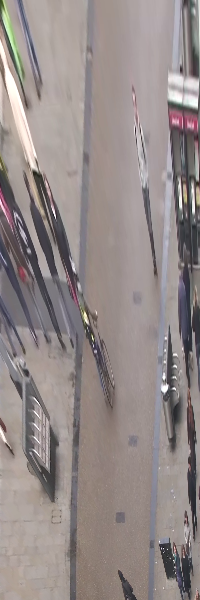

In [ ]:
# transform the region into top-down view (birds-eye view)
region = np.array(region.reshape(4, 2), np.float32)
dst = np.float32([[200, 0], [200, 600], [0, 600], [0, 0]])

M = cv2.getPerspectiveTransform(region, dst)
warped = cv2.warpPerspective(image, M, (200, 600))
cv2_imshow(warped)

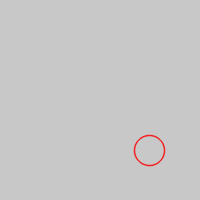

In [ ]:
# a circle to be drawn on the person detected based on the transformed frame
overlay = np.zeros((200, 200, 3), np.uint8)
overlay[:,:,:] = 200
overlay = cv2.circle(overlay, (50, 150), 15, (0, 0, 255), 1, lineType=cv2.LINE_AA)
overlay = cv2.flip(overlay, 1)
cv2_imshow(overlay)

In [ ]:
# calculate the euclidean distance between 2 points
def calculate_distance(point1, point2):
    '''Calculate usual distance.'''
    x1, y1 = point1
    x2, y2 = point2
    return np.linalg.norm([x1 - x2, y1 - y2])

In [ ]:
# convert into birds-eye view
def convert_to_bird(centers, M):
    '''Apply the perpective to the bird's-eye view.'''
    centers = [cv2.perspectiveTransform(np.float32([[center]]), M) for center in centers.copy()]
    centers = [list(center[0, 0]) for center in centers.copy()]
    return centers

In [ ]:
# perform detection using bird's-eye view on frame/image
def bird_detect_people_on_frame(img, confidence, distance, width, height,
                                region=None, dst=None):
    violation_count = 0 # counter for number of violation
    results = model([img[:, :, ::-1]])  # Pass the frame through the model and get the boxes

    xyxy = results.xyxy[0].cpu().numpy()  # xyxy are the box coordinates
    xyxy = xyxy[xyxy[:, 4] >= confidence]  # Filter desired confidence
    xyxy = xyxy[xyxy[:, 5] == 0]  # Consider only people
    xyxy = xyxy[:, :4]

    # Calculate the centers of the circles
    # They will be the centers of the bottom of the boxes
    centers = []
    for x1, y1, x2, y2 in xyxy:
        center = [np.mean([x1, x2]), y2]
        centers.append(center)


    # We create two transformations
    if region is None:
        # The region on the original image
        region = np.float32([[width, 0], [width - 300, 1000], [0, 550], [width - 750, 0]])
    if dst is None:
        # The rectangle we want the image to be trasnformed to
        dst = np.float32([[200, 0], [200, 600], [0, 600], [0, 0]])
    # The first transformation is straightforward: the region to the rectangle
    # as thin the example before
    M = cv2.getPerspectiveTransform(region, dst)

    # The second transformation is a trick, because, using the common transformation,
    # we can't draw circles at left of the region.
    # This way, we flip all things and draw the circle at right of the region,
    # because we can do it.
    region_flip = region*np.float32([-1, 1]) + np.float32([width, 0])
    dst_flip = dst*np.float32([-1, 1]) + np.float32([width, 0])
    M_flip = cv2.getPerspectiveTransform(region_flip, dst_flip)

    # Convert to bird
    # Now, the center of the circles will be positioned on the rectangle
    # and we can calculate the usual distance
    bird_centers = convert_to_bird(centers, M)

    # We verify if the circles colide
    # If so, they will be red
    colors = ['green']*len(bird_centers)
    for i in range(len(bird_centers)):
        for j in range(i+1, len(bird_centers)):
            dist = calculate_distance(bird_centers[i], bird_centers[j])
            if dist < distance:
                colors[i] = 'red'
                colors[j] = 'red'
                violation_count += 1

    # We draw the circles
    # Because we have two transformation, we will start with two empty
    # images ("overlay" images) to draw the circles
    overlay = np.zeros((3*width, 4*width, 3), np.uint8)
    overlay_flip = np.zeros((3*width, 4*width, 3), np.uint8)
    for i, bird_center in enumerate(bird_centers):
        if colors[i] == 'green':
            color = (0, 255, 0)
        else:
            color = (0, 0, 255)
        x, y = bird_center
        x = int(x)
        y = int(y)
        if x >= int(distance/2+15/2):
            # If it's the case the circle is inside or at right of our region
            # we can use the normal overlay image
            overlay = cv2.circle(overlay, (x, y), int(distance/2),
                                  color, 1, lineType=cv2.LINE_AA)
        else:
            # If the circle is at left of the region,
            # we draw the circle inverted on the other overlay image
            x = width - x
            overlay_flip = cv2.circle(overlay_flip, (x, y), int(distance/2),
                                  color, 1, lineType=cv2.LINE_AA)

    # We apply the inverse transformation to the overlay
    overlay = cv2.warpPerspective(overlay, M, (width, height),
                                  cv2.INTER_NEAREST, cv2.WARP_INVERSE_MAP)
    # We apply the inverse of the other transformation to the other overlay
    overlay_flip = cv2.warpPerspective(overlay_flip, M_flip, (width, height),
                                       cv2.INTER_NEAREST, cv2.WARP_INVERSE_MAP)
    # Now we "unflip" what the second overlay
    overlay_flip = cv2.flip(overlay_flip, 1)

    # We add all images
    img = cv2.addWeighted(img, 1, overlay, 1, 0)
    img = cv2.addWeighted(img, 1, overlay_flip, 1, 0)

    text = "Social Distancing Violations: {}".format(violation_count)
    cv2.putText(img, text, (40, height - 75),
                    cv2.FONT_HERSHEY_DUPLEX, 2.5, (0, 0, 255), 3)

    return img, violation_count

In [ ]:
# Inference an image using bird's eye view
path = '/content/social-distancing/ori_images/image1.jpg'
img = cv2.imread(path)

test, count = bird_detect_people_on_frame(img, 0.5, 18, img.shape[1], img.shape[0])
cv2_imshow(test)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# perform detection using bird's-eye view on video
def bird_detect_people_on_video(filename, confidence=0.9, distance=160):
    total_count = 0
    # Capture video
    cap = cv2.VideoCapture(filename)

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    if os.path.exists('bird_output.avi'):
        os.remove('bird_output.avi')
    out = cv2.VideoWriter('bird_output.avi', fourcc, fps, (width, height))

    # Iterate through frames
    vidlen = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    with tqdm(total=vidlen) as pbar:
        while cap.isOpened():
            # Read frame
            ret, frame = cap.read()
            if ret == True:
                # Detect people as a bird
                frame, violation_count = bird_detect_people_on_frame(frame, confidence, distance,
                                                    width, height)
                total_count += violation_count
                # Write frame to new video
                out.write(frame)
                pbar.update(1)
            else:
                break

    return total_count

    # Release everything if job is finished
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
# run the detection on video
violation_counts = bird_detect_people_on_video(filename, confidence=0.5, distance=18)

In [ ]:
# view the output video
display_avi_video('bird_output.avi')

Output hidden; open in https://colab.research.google.com to view.